In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten , BatchNormalization , Lambda , Activation , Dropout

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
TARGET_X = 224
TARGET_Y = 224
BATCH_SIZE = 64
CLASS_NUM = 3
EPOCH = 10

In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('/Users/gustavonrm/Desktop/VCOM/FEUP-VCOM2/multiclass_v2.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].str.split(' ')
train_classes["id"]=train_classes["id"].apply(append_ext)


print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1000fe2e667721fe.png          [51]
1  10041eb49b297c08.png          [51]
2  100501c227f8beea.png          [13]
3  1008abd71f3ed5bc.png           [1]
4  100a0dcde728cb36.png          [51]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

Found 17670 validated image filenames belonging to 3 classes.
Found 4417 validated image filenames belonging to 3 classes.


In [5]:
model = Sequential()

model.add(Conv2D(96, 11, strides=4, padding='same', input_shape=(TARGET_X,TARGET_Y,3)))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(256, 5, strides=4, padding='same'))
model.add(Lambda(tf.nn.local_response_normalization))
model.add(Activation('relu'))
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(384, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, 3, strides=4, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 256)         0

In [6]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy"])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCH,
                    verbose=1)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/10
276/276 [==============================] - 316s 1s/step - loss: 1.0682 - accuracy: 0.4197 - categorical_accuracy: 0.4197 - val_loss: 0.9852 - val_accuracy: 0.5075 - val_categorical_accuracy: 0.5075
Epoch 2/10
276/276 [==============================] - 290s 1s/step - loss: 0.9584 - accuracy: 0.5269 - categorical_accuracy: 0.5269 - val_loss: 0.9375 - val_accuracy: 0.5188 - val_categorical_accuracy: 0.5188
Epoch 3/10
276/276 [==============================] - 284s 1s/step - loss: 0.8710 - accuracy: 0.5870 - categorical_accuracy: 0.5870 - val_loss: 0.8555 - val_accuracy: 0.5901 - val_categorical_accuracy: 0.5901
Epoch 4/10
276/276 [==============================] - 286s 1s/step - loss: 0.8059 - accuracy: 0.6236 - categorical_accuracy: 0.6236 - val_loss: 0.8552 - val_accuracy: 0.5990 - val_cate

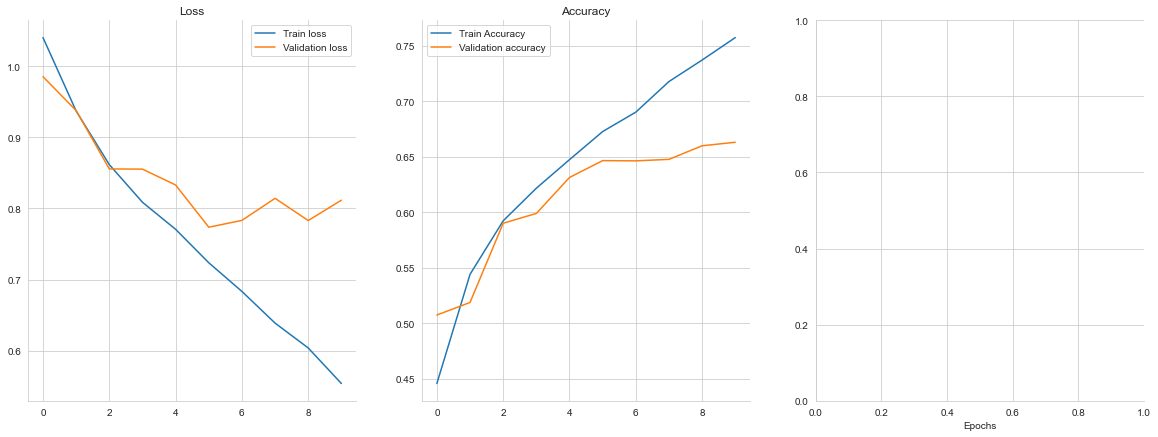

In [7]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()